## Inference

In [38]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from Autoencoder import Autoencoder
import yaml
import os
import cv2
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Instantiate the model and set to eval mode
model = Autoencoder()

# Load model.pth if exists
try:
	model.load_state_dict(torch.load("models/Autoencoder_default.pth"))
except FileNotFoundError:
	print("No model.pth found")
model.to(device)
model.eval()

# Define a transform to preprocess the image
transform = transforms.Compose([
		transforms.Resize(256),
		transforms.ToTensor()
	])

# Load data path
with open("../config.yml", "r") as file:
	config = yaml.safe_load(file)
	data_path = config["dataset_path"]

Using cuda device


In [39]:
# Load and preprocess the image
# image = Image.open(os.path.join(data_path, "CrossValidation/Annotated/B22-25_0/02816.png")) # Negative
image = Image.open(os.path.join(data_path, "CrossValidation/Annotated/B22-37_0/00045_Aug1.png")).convert("RGB") # Positive
input_image = transform(image).unsqueeze(0) # Add batch dimension
print(input_image.shape)

torch.Size([1, 3, 256, 256])


In [40]:
# Perform a forward pass to get the reconstructed image
with torch.no_grad():
    reconstructed_image = model(input_image.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


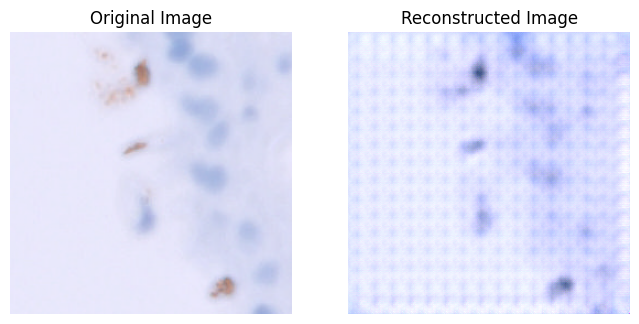

In [41]:
# Convert tensors to images for visualization
input_image_np = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Display the original and reconstructed images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(input_image_np)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis("off")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


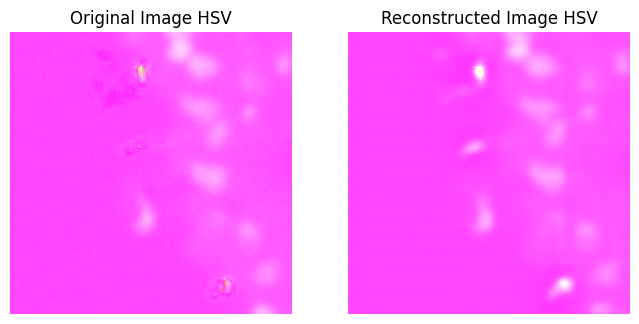

0

In [ ]:
def check_red_fraction(orig, reco, thresh, return_value=False):
	# Convert the images from RGB to HSV
	input_image_hsv = cv2.cvtColor(orig, cv2.COLOR_RGB2HSV)
	reconstructed_image_hsv = cv2.cvtColor(reco, cv2.COLOR_RGB2HSV)

	# Define the hue range for red pixels as suggested
	# For -20 to 0 in HSV, which corresponds to hues 160-180 in OpenCV's scale
	input_lower_hsv1 = np.array([340, 0, 0])
	input_upper_hsv1 = np.array([360, 255, 255])

	# For 0 to 20 in HSV
	input_lower_hsv2 = np.array([0, 0, 0])
	input_upper_hsv2 = np.array([20, 255, 255])

	# Apply masks to the original image
	mask_ori1 = cv2.inRange(input_image_hsv, input_lower_hsv1, input_upper_hsv1)
	mask_ori2 = cv2.inRange(input_image_hsv, input_lower_hsv2, input_upper_hsv2)
	mask_ori = cv2.bitwise_or(mask_ori1, mask_ori2)
	count_red_ori = np.count_nonzero(mask_ori)

	# Apply masks to the reconstructed image
	mask_rec1 = cv2.inRange(reconstructed_image_hsv, input_lower_hsv1, input_upper_hsv1)
	mask_rec2 = cv2.inRange(reconstructed_image_hsv, input_lower_hsv2, input_upper_hsv2)
	mask_rec = cv2.bitwise_or(mask_rec1, mask_rec2)
	count_red_rec = np.count_nonzero(mask_rec)

	# Calculate the fraction of red pixels
	if count_red_rec > 0:
		F_red = count_red_ori / count_red_rec
	else:
		F_red = 0  # Avoid division by zero

	if return_value:
		return F_red
	else:
		return F_red > thresh if F_red is not None else False

check_red_fraction(input_image_np, reconstructed_image_np, 0.5, return_value=True)

In [6]:
from utils import HelicoDatasetClassification
from torch.utils.data import DataLoader

dataset = HelicoDatasetClassification()
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [7]:
next(iter(dataloader))[0].shape, next(iter(dataloader))[1]

(torch.Size([16, 3, 256, 256]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]))

In [8]:
from utils import HelicoDatasetClassification
from torch.utils.data import DataLoader
from tqdm import tqdm

dataset = HelicoDatasetClassification()
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

red_fracs = []
labels = []
for batch in tqdm(dataloader):
	b_orig_images = batch[0].to(device)
	b_labels = batch[1].to(device)
	with torch.no_grad():
		reco_images = model(b_orig_images)
	
	for i in range(len(b_orig_images)):
		red_fracs.append(check_red_fraction(
			b_orig_images[i].permute(1, 2, 0).cpu().numpy(),
			reco_images[i].permute(1, 2, 0).cpu().numpy(),
			0.5,
			return_value=True
		))
	labels.extend(b_labels.cpu().numpy())
labels = np.array(labels)

100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


In [9]:
print(red_fracs[:15])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
print(labels[:15])

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


AUC: 0.944


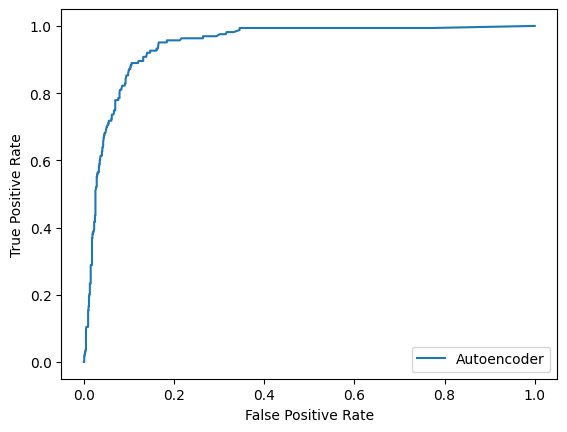

In [25]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# calculate roc curve
fpr, tpr, thresholds = roc_curve(labels, red_fracs)
# calculate AUC
auc = roc_auc_score(labels, red_fracs)
print('AUC: %.3f' % auc)

# plot the roc curve for the model
plt.plot(fpr, tpr, label='Autoencoder')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [12]:
from utils import HelicoDatasetAnomalyDetection
from torch.utils.data import DataLoader
from tqdm import tqdm

dataset = HelicoDatasetAnomalyDetection()
dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)

# Initialize variables to store the sum and sum of squares of pixel values
mean = torch.zeros(4, device=device)
std = torch.zeros(4, device=device)
n_samples = 0

for images in tqdm(dataloader):
	images = images.to(device)
	n_samples += images.size(0)
	mean += images.mean([0, 2, 3])
	std += images.std([0, 2, 3])

mean /= n_samples
std /= n_samples

print(f'Mean: {mean}')
print(f'Std: {std}')

100%|██████████| 32/32 [05:27<00:00, 10.23s/it]


Mean: tensor([0.0004, 0.0004, 0.0005, 0.0005], device='cuda:0')
Std: tensor([4.2069e-05, 3.2273e-05, 2.4717e-05, 0.0000e+00], device='cuda:0')
